In [1]:
# Import from libraries.
from numpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

from shapely.geometry import Point, Polygon, LineString

corners = [(1,3),(-1,3),(-1,-3),(1,-3)]
shape = Polygon(corners) # Shape of magnetized object.

In [7]:
# Define magnetization.

def magnetization(x,y):
    p = Point((x,y))
    if (p.within(shape)):
        mx = 1 # Change this to match your magnetization's x-component.
        my = 0 # Change this to match your magnetization's y-component.
    else:
        mx = 0
        my = 0
    return [mx,my]

In [8]:
# Set constants.
M = 100 # Number of grid squares on a side.
# With magnetization in the xy-plane, A will point in the z-direction.
Aztop = 1e-5 # Magnetic potential z-component at top boundary.
Azbottom = Aztop # Magnetic potential z-component at bottom boundary.
Azleft = Aztop # Magnetic potential z-component at left boundary.
Azright = Aztop # Magnetic potential z-component at right boundary.

xmin = -5 # Starting value of x & y.
xmax = 5 # Ending value of x & y.
dx = (xmax-xmin)/M # Step size. Don't need to change.

# Create arrays to hold magnetic potential values and points.
Az = zeros([M+1,M+1],float) # Current guess for magnetic potential.
Azprime = zeros([M+1,M+1],float) # Next guess for magnetic potential.
xlist = linspace(xmin,xmax,M+1) # List of x-coordinates.
ylist = linspace(xmin,xmax,M+1) # List of y-coordinates.

# Calculate J_b = -curl(magnetization) and K_b = magnetization cross nhat along each border.
J_b = zeros((len(xlist),len(ylist))) # With magnetization in the xy-plane, J_b will point along z-axis.

for i in range(1,len(xlist)-1):
    for j in range(1,len(ylist)-1):
        x = xlist[i]
        y = ylist[j]
        p = Point(x,y)
        posn = array([x,y])
        pbox = Polygon([(x+dx/2,y+dx/2),(x-dx/2,y+dx/2),(x-dx/2,y-dx/2),(x+dx/2,y-dx/2)])
        if (p.within(shape)):
            xr = xlist[i+1]
            xl = xlist[i-1]
            ya = ylist[j+1]
            yb = ylist[j-1]
            dMydx = magnetization(xr,y)[1] - magnetization(xl,y)[1]
            dMxdy = magnetization(x,ya)[0] - magnetization(x,yb)[0]
            J_b[i][j] = (dMydx-dMxdy)/(2*dx)
        elif (pbox.overlaps(shape)):
            # See if we're on an edge.
            nhat = array([0,0])
            for k in range(len(shape.exterior.coords)-1):
                edge = LineString([shape.exterior.coords[k],shape.exterior.coords[k+1]])
                if (not pbox.disjoint(edge)):
                    nhat = array([shape.exterior.coords[k+1][1]-shape.exterior.coords[k][1],shape.exterior.coords[k][0]-shape.exterior.coords[k+1][0]])
            J_b[i][j] = (magnetization(x,y)[0]*nhat[1]-magnetization(x,y)[1]*nhat[0])/dx
print("finished.")

finished.


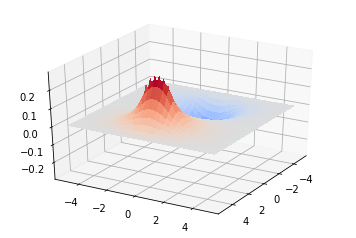

In [9]:
# Set constant boundary conditions.
# Left edge, where i = 0 is fixed.
Az[0,:] = Azleft
# Right edge, where i = M is fixed.
Az[M,:] = Azright
# Bottom edge, where j = 0 is fixed.
Az[:,0] = Azbottom
# Top edge, where j = M is fixed.
Az[:,M] = Aztop

# If you need to set up a funciton along one of the edges,
# follow this example. It sets up Az(x,0) = xmax*x-x**2 along 
# the bottom edge. This is just a function picked for demonstration.
# Use Az[i,0] for the bottom edge, Az[i,M] for the top edge,
# Az[0,j] for the left edge, and Az[M,j] for the right edge.
# for i in range(0,M+1):
#     Az[i,0] = (xmax*xlist[i]-xlist[i]**2)*4/xmax**2

target = 1e-1 # Target accuracy.

# Main loop
delta = 1.0 # Current error between Az and Azprime.
iteration = 0
while delta > target and iteration<1000: # Repeat until error is lower than target accuracy.
    iteration += 1
    # Calculate new values of the potential.
    for i in range(M+1):
        for j in range(M+1):
            if i==0 or i==M or j==0 or j==M: # Endpoitns stay fixed.
                Azprime[i,j] = Az[i,j]
            else:
                # Calculate next guess based on difference equation.
                Azprime[i,j] = (Az[i+1,j]+Az[i-1,j]+Az[i,j+1]+Az[i,j-1])/4 + dx**2/4*J_b[i,j]
    # Calculate maximum difference from old values.
    delta = 1000*delta
    for i in range(len(xlist)):
        for j in range(len(xlist)):
            delta = max(delta,abs(Az[i,j]-Azprime[i,j]))
    # Swap the two arrays.
    Az,Azprime = Azprime,Az

# Turn lists into a format that matplotlib wants.
X, Y = meshgrid(xlist, ylist)

# Set viewing angle for graph.
angle = 30

# Create figure and plot.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Az, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, angle)
plt.draw()

# Need a different view? Change new_angle (in degrees) in the next cell and run it. 
# Then you can regraph your results without having to re-run the computation.

In [10]:
# Calculate magnetic field from the potential's curl.

bfield = array([zeros([len(xlist),len(xlist)]),zeros([len(xlist),len(xlist)])])
for i in range(1,len(xlist)-1):
    for j in range(1,len(xlist)-1):
        bfield[0,i,j] =  (Az[i,j+1] - Az[i,j-1])/(2*dx)
        bfield[1,i,j] = -(Az[i+1,j] - Az[i-1,j])/(2*dx)

# bfield has two lists: The x-components of the magnetic field,
# and the y-components of the magnetic field. 
# It stores this information like so:
# bfield[k][i][j] is the kth-component (k = 0 means x, k = 1 means y)
# of B at the point(xlist[i],ylist[j])

# Find maximum magnetic field magnitude to scale arrows later.
bmax = 0.0
for k in range(2):
    for i in range(len(xlist)):
        for j in range(len(ylist)):
            if (bmax<abs(bfield[k][i][j])):
                bmax = abs(bfield[k][i][j])


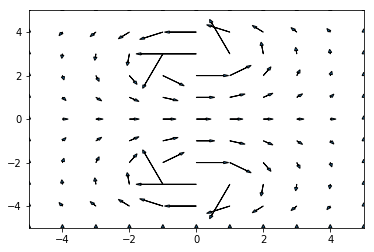

In [11]:
# Graph the magnetic field.

# Set visual scale factors. Adjust as necessary to make e-field visible.
arrow_length_scale_factor = 20 # Increase to make arrows longer.
arrow_head_scale_factor = 1 # Increase to make arrowheads larger.
arrow_skip = 10 # Increase to show fewer arrows.

bscale = dx/bmax*arrow_length_scale_factor
b_fig = plt.figure()
b_ax = b_fig.add_subplot()
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
for i in range(0,len(xlist),arrow_skip):
    for j in range(0,len(ylist),arrow_skip):
        plt.arrow(xlist[i],ylist[j],bfield[0][i][j]*bscale,bfield[1][i][j]*bscale,head_width=dx*arrow_head_scale_factor)